# DEMO: Model Building and Scoring (Logistic Regression)

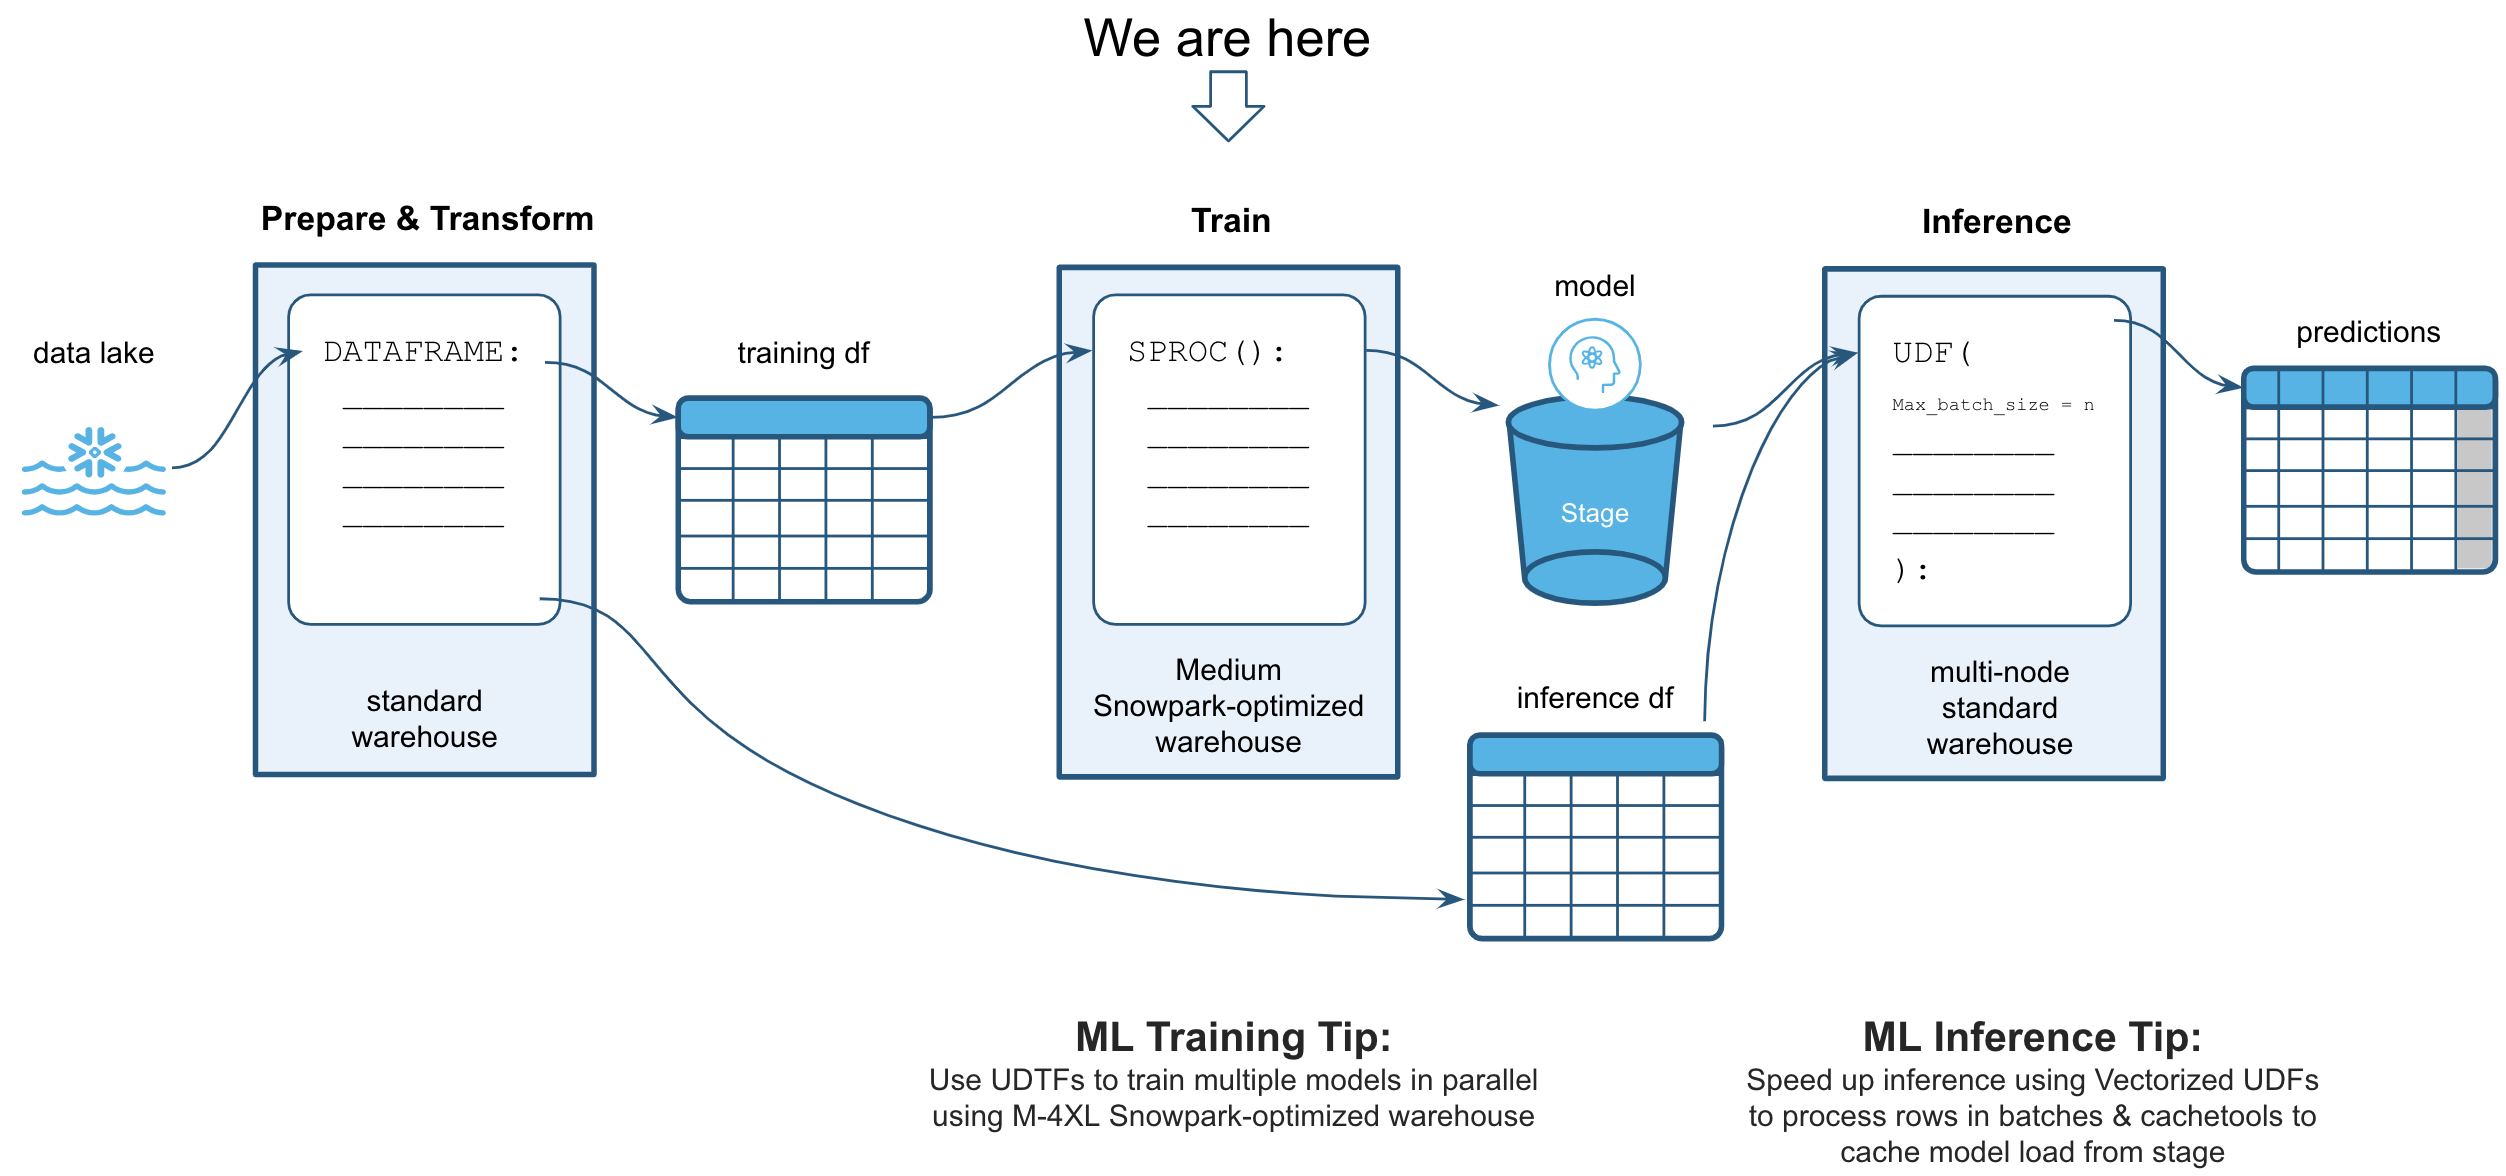

## Imports

In [ ]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
import preprocessing

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create Snowpark Session

In [ ]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [ ]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

## Prepare Snowflake Stage to store Models

In [ ]:
session.sql('CREATE OR REPLACE STAGE ML_MODELS').collect()

In [ ]:
pd.DataFrame(session.sql('SHOW STAGES').collect())

# Model Building

We will use the balanced data set we created in the last part.

In [ ]:
application_record_balanced_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
application_record_balanced_sdf.group_by('TARGET').count().show()

Since we want to use stratified sampling to create training and test data sets and snowpark does not  

In [ ]:
train_sdf = application_record_balanced_sdf.sample_by("TARGET", {1: 0.8, 0: 0.8})
train_sdf = train_sdf.cache_result()
train_sdf.group_by('TARGET').count().show()

In [ ]:
test_sdf = application_record_balanced_sdf.minus(train_sdf)
test_sdf.group_by('TARGET').count().show()

In [ ]:
train_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN', mode='overwrite')
test_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TEST', mode='overwrite')

In [ ]:
# Check the versions of the scikit-learn python library in Snowflake
session.table("information_schema.packages")\
        .filter((F.col("language") == 'python') & (F.col("PACKAGE_NAME") == 'scikit-learn'))\
        .sort(F.col("PACKAGE_NAME").asc(), F.col("VERSION").desc()).show(20)

In [ ]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake

def sproc_train_logistic_reg_model(session: Session, 
                                   training_table: str, 
                                   feature_cols: list,
                                   target_col: str,
                                   model_name: str) -> T.Variant:
    
    from joblib import dump
    import os
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # Actual model training
    from sklearn.linear_model import LogisticRegression
    lm = LogisticRegression(C=0.8, solver='lbfgs',random_state=0)
    lm.fit(X,y)
    
    # Getting model coefficients
    coeff_df = pd.DataFrame(lm.coef_.T,lm.feature_names_in_,columns=['Coefficient']).to_dict()

    # Save model as file and upload to Snowflake stage
    model_file = os.path.join('/tmp', model_name)
    dump(lm, model_file)
    session.file.put(model_file, '@ML_MODELS', auto_compress=False, overwrite=True)
    
    return coeff_df

In [ ]:
# Registering the function as a Stored Procedure
sproc_train_logistic_reg_model = session.sproc.register(func=sproc_train_logistic_reg_model, 
                                                        name='sproc_train_lm_model', 
                                                        is_permanent=True, 
                                                        replace=True, 
                                                        stage_location='@ML_MODELS', 
                                                        packages=['snowflake-snowpark-python','scikit-learn==1.1.1'
                                                                  ,'joblib'])

In [ ]:
training_table = 'CREDIT_RISK_PREPARED_BALANCED_TRAIN'
# get feature columns
feature_cols = train_sdf.columns
feature_cols.remove('ID')
feature_cols.remove('TARGET')
target_col = 'TARGET'
model_name = 'logistic_reg_model.sav'

feature_coefficients = sproc_train_logistic_reg_model(training_table, 
                                                      feature_cols, 
                                                      target_col,
                                                      model_name, 
                                                      session=session)

feature_coefficients = pd.DataFrame(eval(feature_coefficients))

In [ ]:
# The model is now stored in a Snowflake stage
pd.DataFrame(session.sql('LIST @ML_MODELS').collect())

In [ ]:
# Plot Feature Coefficients
feature_coefficients.sort_values('Coefficient').plot.barh(y='Coefficient', figsize=(5,15))

# Model Scoring

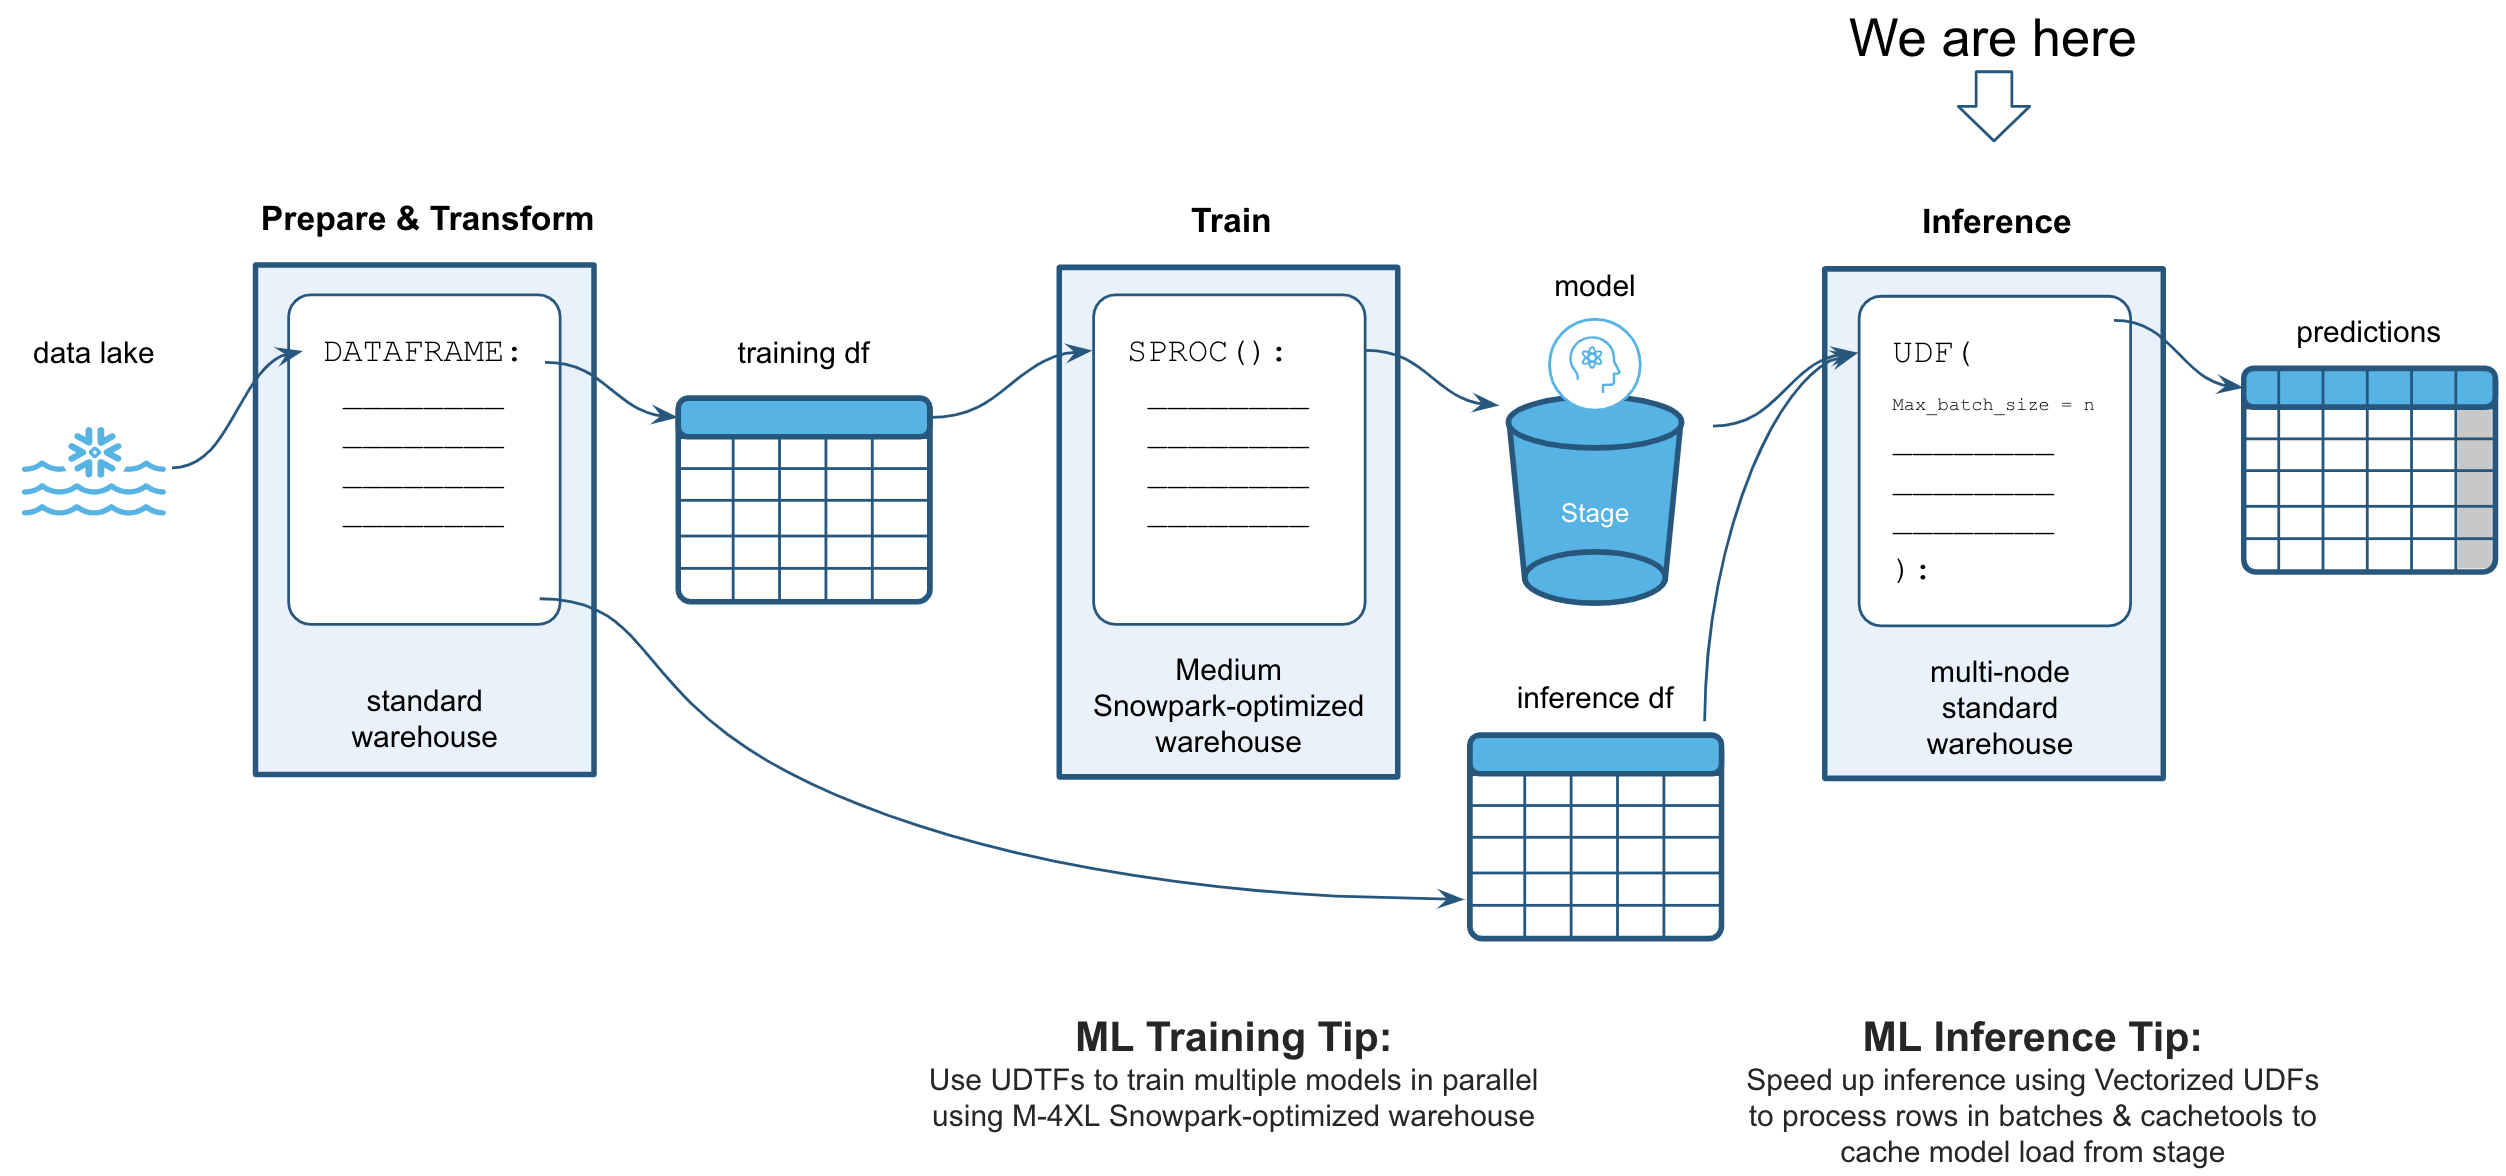

In [ ]:
# Define a simple scoring function
def udf_score_logistic_reg_model(*args) -> float:
    import os
    import sys
    from joblib import load
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load(import_dir+model_name)
    scored_data = model.predict(pd.DataFrame([args]))[0]
    return scored_data

In [ ]:
# Register UDF
udf_score_logistic_reg_model = session.udf.register(func=udf_score_logistic_reg_model, 
                                                    name="udf_score_logistic_reg_model", 
                                                    stage_location='@ML_MODELS',
                                                    input_types=[T.FloatType()]*len(feature_cols),
                                                    return_type = T.FloatType(),
                                                    replace=True, 
                                                    is_permanent=True, 
                                                    imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                    packages=['scikit-learn==1.1.1','pandas','joblib'], 
                                                    session=session)

In [ ]:
# Lets disable result-cache for a moment to see true scoring-performance
session.sql('ALTER SESSION SET USE_CACHED_RESULT = FALSE').collect()

In [ ]:
%%time
# Scoring with a Scalar UDF (one row at a time)
# We will implement a faster approach in chapter 3
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

In [ ]:
# Lets re-enable result-cache
session.sql('ALTER SESSION SET USE_CACHED_RESULT = TRUE').collect()

# Model Evaluation

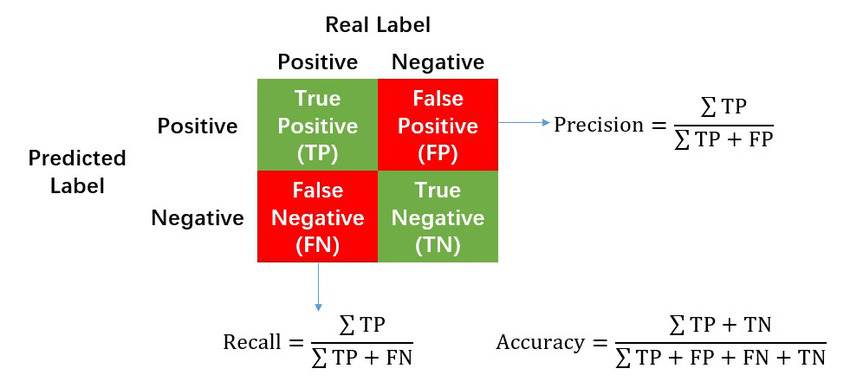

In [ ]:
scored_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED')

In [ ]:
# Obtaining a simple confusion matrix
scored_sdf.group_by(['TARGET','PREDICTION']).count().to_pandas()

In [ ]:
scored_sdf.group_by(['TARGET','PREDICTION']).count()\
            .with_column("type", F.when((F.col("TARGET") == 0) & (F.col("PREDICTION") == 0), "tn")\
                                .when((F.col("TARGET") == 0) & (F.col("PREDICTION") == 1), "fp")\
                                .when((F.col("TARGET") == 1) & (F.col("PREDICTION") == 0), "fn")\
                                .when((F.col("TARGET") == 1) & (F.col("PREDICTION") == 1), "tp"))\
            .select(["TYPE", "COUNT"]).pivot("TYPE", ['tn', 'tp', 'fn', 'fp']).sum("COUNT")\
            .with_columns(["accuracy", "precision", "recall"],
                         [((F.col("'tp'") + F.col("'tn'")) / (F.col("'tp'") + F.col("'tn'") + F.col("'fn'") + F.col("'fp'")))
                         , (F.col("'tp'") / (F.col("'tp'") + F.col("'fp'")))
                          ,(F.col("'tp'") / (F.col("'tp'") + F.col("'fn'")))])\
            .with_column("f1", (F.lit(2)*F.col("precision")*F.col("recall")) / (F.col("precision")+F.col("recall")))\
            .select(["ACCURACY","PRECISION", "RECALL","F1"]).show()


In [ ]:
session.close()